# 집값 예측 경진대회

## 패키지 import 및 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [397]:
df = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/train.csv')
test = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/test.csv')

In [398]:
df.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


`-` id는 필요없으니 제거

In [399]:
df.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

`-` 결측치는 없다

`-` 분석의 편의를 위해 컬럼명을 바꾸겠다

In [516]:
## 공백과 슬래쉬를 _로 대체 1을 숫자가 아닌 다른 문자로 바꿈 

df.rename(columns = dict(zip(df.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'fir') for column in df.columns])), inplace = True) 
test.rename(columns = dict(zip(test.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'fir') for column in test.columns])), inplace = True) 

`-` 범주형 변수는 Exter Qual(외관 재료 품질;4개), Kitchen Qual(부엌 품질; 4개), Bsmt Qual(지하실 높이;5개)이다

`-` 총 5개의 등급이 존재하는데 Poor 등급은 Bsmt Qual에 1개 존재한다(나머지는 0개)

`-` 아예 poor등급이 존재하지 않는걸 수 도 있고 poor등급이 존재하는데 poor등급에 해당하는 건물이 존재하지 않는걸 수 도 있다

`-` 편의상 후자라고 생각하자

`-` 이들은 순서형 변수이므로 라벨 인코딩을 해주자

`-` 좋은 등급이 큰 값을 가지도록 하기위해 라벨인코딩을 정의해주자

In [401]:
def label_encoding(data):
    grade_label = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] ## 0~4점
    
    for grade, label in enumerate(grade_label):
        if data == label:
            return grade

In [402]:
for col in df.columns[df.dtypes == 'object']:
    df[col] = df[col].apply(lambda x: label_encoding(x))

In [403]:
df.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt,target
0,10,2392,4,3,968,4,2392,2392,4,2,2003,2003,2003,386250
1,7,1352,3,2,466,3,1352,1352,4,2,2006,2007,2006,194000
2,5,900,2,1,288,2,864,900,2,1,1967,1967,1967,123000
3,5,1174,2,2,576,3,680,680,2,1,1900,2006,2000,135000
4,7,1958,3,3,936,3,1026,1026,3,2,2005,2005,2005,250000


`-` 라벨 인코딩이 잘 되었다

`-` 앞서 EDA에서 집값(target)이 오른쪽으로 꼬리가 긴 분포임을 확인했다

`-` 정규분포로 맞춰주기 위해 로그변환을 하자

In [404]:
import scipy.stats as stats

<AxesSubplot:>

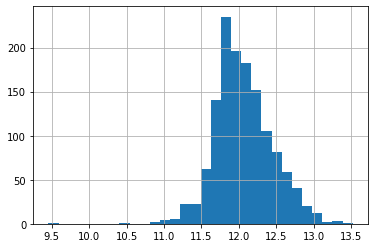

In [405]:
np.log(df['target']).hist(bins = 30)

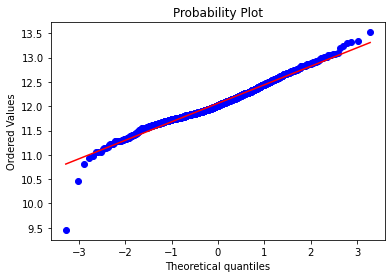

In [406]:
_ = stats.probplot(np.log(df['target']), plot = plt)

`-` 로그 변환을 했지만 정규분포를 따르지 않는것처럼 보인다

`-` 샤피로-윌크 검정을 통해 정확히 확인하자

In [407]:
test_stat, p_val = stats.shapiro(np.log(df['target']))

In [408]:
p_val, np.log(df['target']).skew() ## p값과 왜도

(4.748497602069524e-13, 0.08070163740417918)

`-` 안타깝게도 정규분포를 따르지 않는다

`-` 왜도는 $0.08$로 거의 $0$

`-` 그런데 Q-Q플랏을 보면 심각한 이상치가 보인다(-3부근에 2개)

`-` 저런 이상치를 예측하는 것은 불가능해보이니 제거하자

In [409]:
df = df.query('target > 50000') ## 5만달러보단 저렴한 집(2개)은 심각한 이상점이므로 제외하자

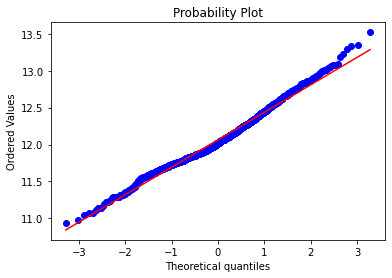

In [410]:
_ = stats.probplot(np.log(df['target']), plot = plt)

`-` 값이 큰쪽으로도 이상점이 있는데 제거할지 말지 고민중이다

In [411]:
df.query('target > 500000 or Overall_Qual == 10')

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt,target
0,10,2392,4,3,968,4,2392,2392,4,2,2003,2003,2003,386250
120,10,2393,4,2,846,4,970,1469,3,2,1998,1999,1998,345000
150,10,2007,4,3,812,4,1017,1026,4,2,2008,2008,2008,310000
201,10,2775,4,2,880,3,1237,1521,2,3,1893,2000,1988,325000
416,10,2332,4,3,846,4,1682,1742,4,2,2007,2008,2008,426000
462,10,3627,3,3,807,3,1930,1831,4,3,1995,1996,1995,625000
683,10,3608,3,3,840,4,1107,1518,2,2,1892,1993,1993,475000
732,9,2338,4,3,1110,3,2660,2338,4,2,2006,2007,2005,591587
789,10,1718,4,3,786,4,1700,1718,4,2,2006,2007,2008,337500
856,10,4476,3,3,813,4,2396,2411,4,3,1996,1996,1996,745000


`-` 가장 비싼 집이 745000 달러인데 Gr_Liv_Area(지상층 생활 면적)이 4476으로 매우 넓다!

`-` 근데 생각해보니 제거하는 것이 맞는 것 같다(6개의 심각한 이상치로 인해 큰 영향을 끼칠 수 있음)

In [412]:
df = df.query('target < 500000') ## 50만 달러보다 비싼 집도 제외하자, 기준은 바뀔 수 있음

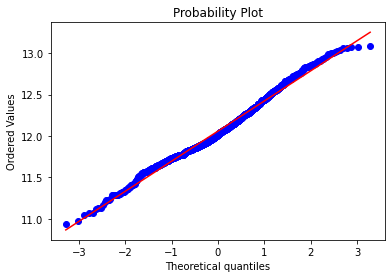

In [413]:
_ = stats.probplot(np.log(df['target']), plot = plt)

<AxesSubplot:>

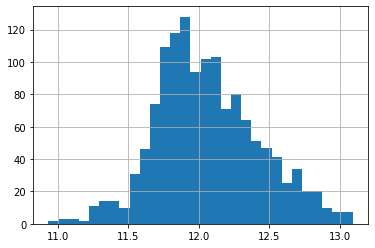

In [414]:
np.log(df['target']).hist(bins = 30)

In [415]:
test_stat, p_val = stats.shapiro(np.log(df['target']))

In [416]:
p_val, np.log(df['target']).skew() ## p값과 왜도

(1.0687537077558318e-08, 0.28208736513525146)

`-` 로그 변환대신 box-cox 변환을 해보자

`-` box-cox 수식 : https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation

<AxesSubplot:>

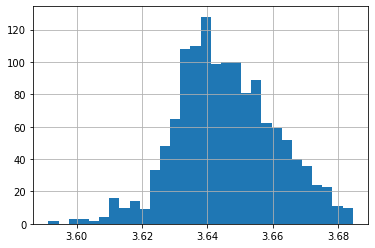

In [417]:
pd.Series(stats.boxcox(df['target'])[0]).hist(bins = 30)

`-` 히스토그램은 로그변환과 비슷해보임

In [418]:
test_stat, p_val = stats.shapiro(stats.boxcox(df['target'])[0])

In [419]:
p_val, pd.Series(stats.boxcox(df['target'])[0]).skew() ## p값과 왜도

(7.786380592733622e-06, -4.04804661662393e-05)

`-` 로그 변환보다 box-cox 변환이 더 우수한 변환으로 보인다

`-` 그런데 box-cox 변환을 하고 다시 원래의 값으로 바꿔야 하는데 어떻게 해야할지 모른다

`-` 그래서 일단은 로그 변환을 하자

## 모델링(선형 회귀)

`-` 간단하게 다중 선형 회귀를 해보자

### 변수 선택(뒤로부터 제거)

In [420]:
from sklearn.model_selection import train_test_split

In [482]:
df.shape ## 총 9개의 이상점을 제거함(더 있지만 일단은 냅둠)

(1341, 14)

In [492]:
dt = df.copy()

In [494]:
dt.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

`-` EDA를 했을 땐 연도가 의미있는 변수가 아니어서 모델링에 사용하지 않겠다

In [496]:
target = dt['target']  ## target
dt = dt.iloc[:, :-1]   ## target 제외한 데이터프레임

In [497]:
x_train, x_valid, y_train, y_valid = train_test_split(dt, target, test_size = 0.2, shuffle = True, random_state = 22)

## 표본크기가 1341로 커서 일단 교차검증은 하지 않음

In [498]:
y_train = np.log(y_train) ## 로그 변환

In [488]:
import statsmodels.formula.api as smf

In [539]:
tmp = pd.concat([x_train, y_train], axis = 1)

In [540]:
tmp.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,target
904,7,1536,3,2,532,3,1536,1536,3,2,12.273731
443,5,1588,2,2,480,2,768,1024,2,1,11.918391
22,7,1651,2,1,276,2,725,1035,2,2,12.055250
389,6,1152,2,2,412,2,912,1152,2,1,11.873742
681,8,1226,3,2,484,3,1226,1226,3,1,12.043554


`-` 선형회귀는 표준화를 하나 안하나 상관없어서 일단은 하지 않겠다

`-` 표준화를 하면 계수를 통해 중요성을 알 수 있긴 함

In [541]:
rst = smf.ols(formula = 'target~' + '+'.join(tmp.columns[:-1]), data = tmp).fit()
# rst.summary()

`-` Full_Bath 변수의 p값이 가장 유의하지 않으니 제거

In [542]:
tmp.drop('Full_Bath', axis = 1, inplace = True)

In [543]:
rst2 = smf.ols(formula = 'target~' + '+'.join(tmp.columns[:-1]), data = tmp).fit()
# rst2.summary()

`-` Exter_Qual 변수의 p값이 가장 유의하지 않으니 제거

In [544]:
tmp.drop('Exter_Qual', axis = 1, inplace = True)

In [545]:
rst3 = smf.ols(formula = 'target~' + '+'.join(tmp.columns[:-1]), data = tmp).fit()
# rst3.summary()

`-` Garage_Cars 변수의 p값이 가장 유의하지 않으니 제거

In [546]:
tmp.drop('Garage_Cars', axis = 1, inplace = True)

In [547]:
rst4 = smf.ols(formula = 'target~' + '+'.join(tmp.columns[:-1]), data = tmp).fit()
rst4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     895.5
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:51:36   Log-Likelihood:                 581.62
No. Observations:                1072   AIC:                            -1147.
Df Residuals:                    1064   BIC:                            -1107.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.4642      0.022    477.262      0.000      10.421      10.507
Overall_Qual      0.0811      0.006     14.438      0.000       0.070       0.092
Gr_Liv_Area       0.0003   1.23e-05     20.641      0.000       0.000       0.000
Garage_Area       0.0001   2.87e-05      5.025      0.000     8.8e-05       0.000
Kitchen_Qual      0.0669      0.009      7.325      0.000       0.049       0.085
Total_Bsmt_SF     0.0001   2.41e-05      5.363      0.000    8.21e-05       0.000
first_Flr_SF   7.197e-05   2.54e-05      2.830      0.005    2.21e-05       0.000
Bsmt_Qual         0.0931      0.009     10.801      0.000       0.076       0.110
==============================================================================
Omnibus:                       97.915   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.586
Skew:                          -0.639   Prob(JB):                     4.95e-36
Kurtosis:                       4.417   Cond. No.                     1.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

`-` 다중공선성이 있다는 메시지가 있는데 이는 표준화를 통해 해결할 수 있다(나중에 하자)

`-` 더 이상 유의하지 않은 피쳐는 없으므로 최종 모형은 rst4이다

### 잔차의 정규성 확인

<AxesSubplot:>

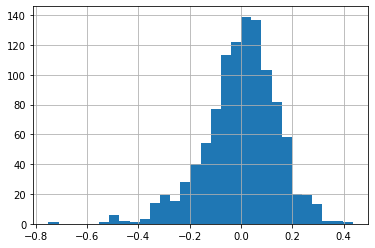

In [461]:
rst4.resid.hist(bins = 30)

Text(0.5, 1.0, 'fitted vs residual')

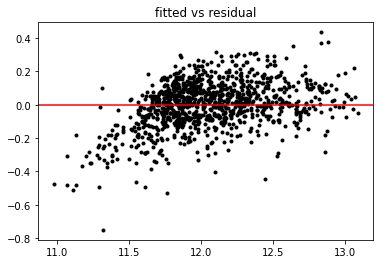

In [462]:
plt.plot(y_train, rst4.resid, '.k')
plt.axhline(0, 0.0, 1.0, color = 'red')
plt.title('fitted vs residual')

`-` 보면 문제가 있음(잔차가 정규분포를 안따름)

`-` 애초에 집값의 분포가 오른쪽으로 꼬리가 매우 긴 분포였고

`-` 로그 변환도 했지만 정규분포를 따르지 않았기에

`-` 이 정도는 그냥 넘어가자(사실 그러면 안 될 것 같지만...)

`-` 어떻게 해결할지 고민하자(독립 변수도 정규분포로 맞춰줘야 함)

In [508]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

In [532]:
## target을 로그 변환 했으므로 원래의 상태로 되돌리기 위해 exp를 취한다
NMAE(np.exp(y_train), np.exp(rst4.predict(x_train.drop(['Full_Bath', 'Exter_Qual', 'Garage_Cars'],  axis = 1))))

0.10197978889761221

`-` train 셋에 대한 NAME는 약 $0.1020$이다

In [528]:
## target을 로그 변환 했으므로 원래의 상태로 되돌리기 위해 exp를 취한다
NMAE(y_valid, np.exp(rst4.predict(x_valid.drop(['Full_Bath', 'Exter_Qual', 'Garage_Cars'],  axis = 1))))

0.08682483720006832

`-` valid 셋에 대한 NMAE는 약 $0.0868$이다

### test 예측

In [563]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/sample_submission.csv')

`-` test 데이터에 대해 라벨인코딩을 해주자

In [520]:
for col in test.columns[test.dtypes == 'object']:
    test[col] = test[col].apply(lambda x: label_encoding(x))

In [534]:
test.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt
0,9,1800,3,2,702,4,1800,1800,4,2,2007,2007,2007
1,6,1082,2,1,240,2,1082,1082,2,1,1948,1950,1948
2,6,1573,3,2,440,3,756,769,3,2,2000,2000,2000
3,6,2443,3,3,744,3,1158,1158,3,2,2004,2004,2004
4,5,1040,2,2,686,2,1040,1040,2,1,1968,1968,1991


`-` 모델을 만들자

In [560]:
model = smf.ols(formula = 'target~' + '+'.join(dt.drop(['Full_Bath', 'Exter_Qual', 'Garage_Cars'],  axis = 1).columns),
                data = pd.concat([dt.drop(['Full_Bath', 'Exter_Qual', 'Garage_Cars'],  axis = 1), np.log(target)], axis = 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     1132.
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:55:38   Log-Likelihood:                 747.79
No. Observations:                1341   AIC:                            -1480.
Df Residuals:                    1333   BIC:                            -1438.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.4640      0.019    538.646      0.000      10.426      10.502
Overall_Qual      0.0826      0.005     16.741      0.000       0.073       0.092
Gr_Liv_Area       0.0002   1.08e-05     22.496      0.000       0.000       0.000
Garage_Area       0.0001   2.56e-05      5.791      0.000    9.79e-05       0.000
Kitchen_Qual      0.0681      0.008      8.460      0.000       0.052       0.084
Total_Bsmt_SF     0.0001   2.15e-05      6.744      0.000       0.000       0.000
first_Flr_SF   6.036e-05   2.21e-05      2.727      0.006    1.69e-05       0.000
Bsmt_Qual         0.0921      0.008     11.796      0.000       0.077       0.107
==============================================================================
Omnibus:                      155.305   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.434
Skew:                          -0.726   Prob(JB):                     5.78e-66
Kurtosis:                       4.808   Cond. No.                     1.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

`-` 이제 예측하자

In [578]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = np.exp(model.predict(test))

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,348354.056444
1,2,133485.003772
2,3,170258.092173
3,4,239000.266354
4,5,128839.067660


In [582]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/submission1.csv', index = False)

`-` 반올림을 일의 자리에서 한 것과 하지 않은 것을 제출해봤는데 거의 비슷했다(한 것이 좋았음)

`-` 반올림 한 것의 점수는 $0.1135657683$

`-` train과 valid의 NMAE에 비해 더 높게 나왔는데 이는 잔차항을 살펴봤을 때 정규성을 띄지 않아

`-` 일반화 성능이 떨어진 것이 드러난 것이다